In [1]:
# imports
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# load in data
df = pd.read_csv('../data/returns_clean.csv', parse_dates = ['timestamp'], 
                                      index_col = 'timestamp')

coin_names = [col.split('_')[0] for col in df.columns]

In [2]:
df2 = df.copy()

df2 -= df2.mean()
df2 /= df2.std()

In [3]:
U, S, Vt = np.linalg.svd(df2)
px.scatter(x = Vt[0, :], y = Vt[1, :], 
           labels = coin_names, color = coin_names,
           title = "Latent Relationships Between Different Crypto Tokens")

In [4]:
# latent relationships between different trading days
trading_days = np.arange(len(df.index))
px.scatter(x = U[:, 0], y = U[:, 1], 
           hover_name = df.index, color = trading_days,
           title = "Latent Relationships Between Different Trading Days During Dataset")

**TO DO:** 

Try and cluster w/ KMeans + PCA

 - Use PCA to reduce dimensionality of dataset (probably keep 95% of explained variance)
 - Fit KMeans to find optimal # of clusters using Silhouette Score (or some other metric) w/ training, validation, test sets (can report these scores in our final report)
 - Visualize on reduced dataset similar to above chart, but this time color coded w/ cluster labels (how well do different clusters separate themselves?)
 - Report patterns contained within different clusters -- any overarching themes?

Mark W's note on above - are there certain clusters we already have in mind? In terms of training/validation/test?

### Finding the amount of PCA components that fits the 95%+ threshold of explained variance

First, we try performing PCA w/ crypto prices as the features.

Here, we see 144 PCA components are required to explain 95% of the variance, thus reducing the dimensionality from 189 (various crypto prices) to 144 features.

In [5]:
from sklearn.decomposition import PCA

n_component = [x for x in range(1,189)]
explained_var = []

for nc in n_component:
    pca = PCA(n_components=nc)
    pca.fit(df2)
    explained_var.append(np.sum(pca.explained_variance_ratio_))

explained_var_pca_df = pd.DataFrame()
explained_var_pca_df['number_of_components'] = n_component
explained_var_pca_df['explained_variance'] = explained_var


fig = px.line(explained_var_pca_df, x="number_of_components", y="explained_variance", title='Explained Variance by Number of PCA Components',markers=True)

fig.show()


In [6]:
pca = PCA(n_components=144)
pca.fit(df2)

df_reduced_16 = pca.transform(df2)
df_reduced_16 = pd.DataFrame(df_reduced_16)
df_reduced_16.index = df2.index

### Exploring Clustering

Similar the 2nd graph, exploring just 2 or 3 principal components to identify any distince clusters indicates that distinct clusters do not form with 2 or 3 principal components. I.e. it is difficult to identify distinct clusters visually.

In [7]:

trading_days = np.arange(len(df_reduced_16.index))

px.scatter(df_reduced_16, x = 0, y = 3,
           hover_name = df_reduced_16.index,
           title = "Two Dimensional Clustering")

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(df_reduced_16)


Below, we can see that creating 2 clusters with KMeans (using all 16 components), tends to arbitraily separate the coins. Visualized through different combinations of components, the clustering looks arbitrary. 

It would be more valuable to separate the central points from the periphery points.

In [9]:
df_reduced_16['kmeans_labels'] = kmeans.labels_

px.scatter(df_reduced_16, x = 0, y = 3,
           hover_name = df_reduced_16.index, color="kmeans_labels",
           title = "Two Dimensional Clustering")

HDBScan, a density based clustering method (an iteration on DBScan), looks for 'islands of higher density amid noise'. Here, after some tuning, we find HBDScan's 3 identified clusters mapped against the top 2 principal components, indicating how the central cluster is surrounded by another extended cluster surrounding it. Additionally, there is a small isolated cluster (not as distinct when viewed in the context of the top 2 principal components).

In [10]:
import hdbscan

if "kmeans_labels" in df_reduced_16.columns:
    df_reduced_16 = df_reduced_16.drop(columns=['kmeans_labels'])

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=6, gen_min_span_tree=True)
hbd_labels = clusterer.fit_predict(df_reduced_16)

df_reduced_16['hbd_labels'] = hbd_labels

px.scatter(df_reduced_16, x = 0, y = 1,
           hover_name = df_reduced_16.index, color="hbd_labels",
           title = "HBDScan's 3 Clusters Viewed through the top 2 principal components")

Applied with the whole non-reduced dataset, HDBScan identifes 4 clusters.

In [11]:

if "hbd_labels" in df2.columns:
    df2 = df2.drop(columns=['hbd_labels'])

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=6, gen_min_span_tree=True)
hbd_labels = clusterer.fit_predict(df_reduced_16)

df2['hbd_labels'] = hbd_labels
print(f'hdbscan identifies {len(np.unique(hbd_labels))} clusters')

hdbscan identifies 1 clusters


### Feature Reduction of the Time Series (reducing time periods)

Attempting PCA with the time periods as features (rather than the coin prices)

In [12]:
df2_T = df2.T


n_component = [x for x in range(1,df2.T.shape[0])]
explained_var = []


for nc in n_component:
    pca = PCA(n_components=nc)
    pca.fit(df2_T)
    explained_var.append(np.sum(pca.explained_variance_ratio_))

explained_var_pca_df = pd.DataFrame()
explained_var_pca_df['number_of_components'] = n_component
explained_var_pca_df['explained_variance'] = explained_var


fig = px.line(explained_var_pca_df, x="number_of_components", y="explained_variance", title='Explained Variance by Number of PCA Components',markers=True)

fig.show()


In [13]:

pca = PCA(n_components=153)
pca.fit(df2_T)
df_reduced_T = pca.transform(df2_T)
df_reduced_T = pd.DataFrame(df_reduced_T)
df_reduced_T.index = df2_T.index
df_reduced_T

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
bitcoin_price,-11.103030,-6.729897,-4.894514,1.946731,2.310079,-7.618736,4.811619,-1.543445,-4.037439,-1.419180,...,0.210237,-0.557981,0.573058,0.504764,0.742299,0.357335,1.120716,0.081893,-2.923148,-1.462455
ethereum_price,-12.398350,-6.744519,-1.796320,-1.144676,0.410987,-5.265977,3.803310,1.880685,1.309800,-1.565962,...,0.358432,-0.913248,-0.324115,-1.252994,-0.290047,0.695050,-0.495672,-0.202544,-0.706669,-1.149362
tether_price,32.412028,-1.381185,23.475579,4.050008,1.318433,-5.265992,3.111661,-4.149293,2.242863,-0.169890,...,0.925637,-0.449215,0.066780,-0.973073,-1.292475,-0.836256,0.513591,-0.278540,1.129426,0.231567
binance-coin_price,-9.452695,-4.147051,0.422183,2.497183,10.432988,-3.978795,-4.971162,1.624842,2.005351,0.462537,...,1.462599,-0.485414,0.010782,-0.480760,-1.537078,-0.027816,0.466057,0.664838,1.710791,1.458859
usd-coin_price,34.590925,-0.614989,23.764060,5.155643,1.195410,-4.453762,2.481783,-2.636282,0.663803,-0.462508,...,0.291861,-0.330800,-0.516237,-0.095725,0.100220,1.029985,-0.070346,-0.114552,0.168531,1.141303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aeternity_price,-5.008846,-1.127033,1.015835,4.198984,-2.063345,6.247820,-2.269620,-4.789213,2.430632,-0.365461,...,0.696747,0.504468,1.092438,2.257855,3.470810,1.737554,2.948126,-0.293905,-0.641091,-1.674516
streamr-datacoin_price,-2.652281,-0.528921,0.726903,-3.940855,0.072446,1.238184,-2.704022,-5.877449,-2.666114,-4.901386,...,0.696829,-0.172458,-0.152577,-2.220237,-0.759856,0.587362,0.008062,-0.638009,0.624273,0.697466
pivx_price,-4.620004,-0.137113,0.828507,0.650620,1.870970,2.865611,-3.340969,-3.309808,-2.746104,-0.003324,...,-0.826631,-1.267665,0.255881,-0.609706,1.007297,-2.188878,1.531503,1.233407,0.984863,-1.110998
neblio_price,0.961853,-1.143612,-0.280659,-0.675507,2.491902,2.194601,-2.382589,-5.106281,-3.098919,0.014908,...,0.923816,1.423496,0.048429,-0.528422,1.479012,-0.513333,-1.200057,0.503902,0.280751,-0.214443


In [14]:
fig = px.imshow(df_reduced_T.T.corr(), text_auto=True)
fig.show()

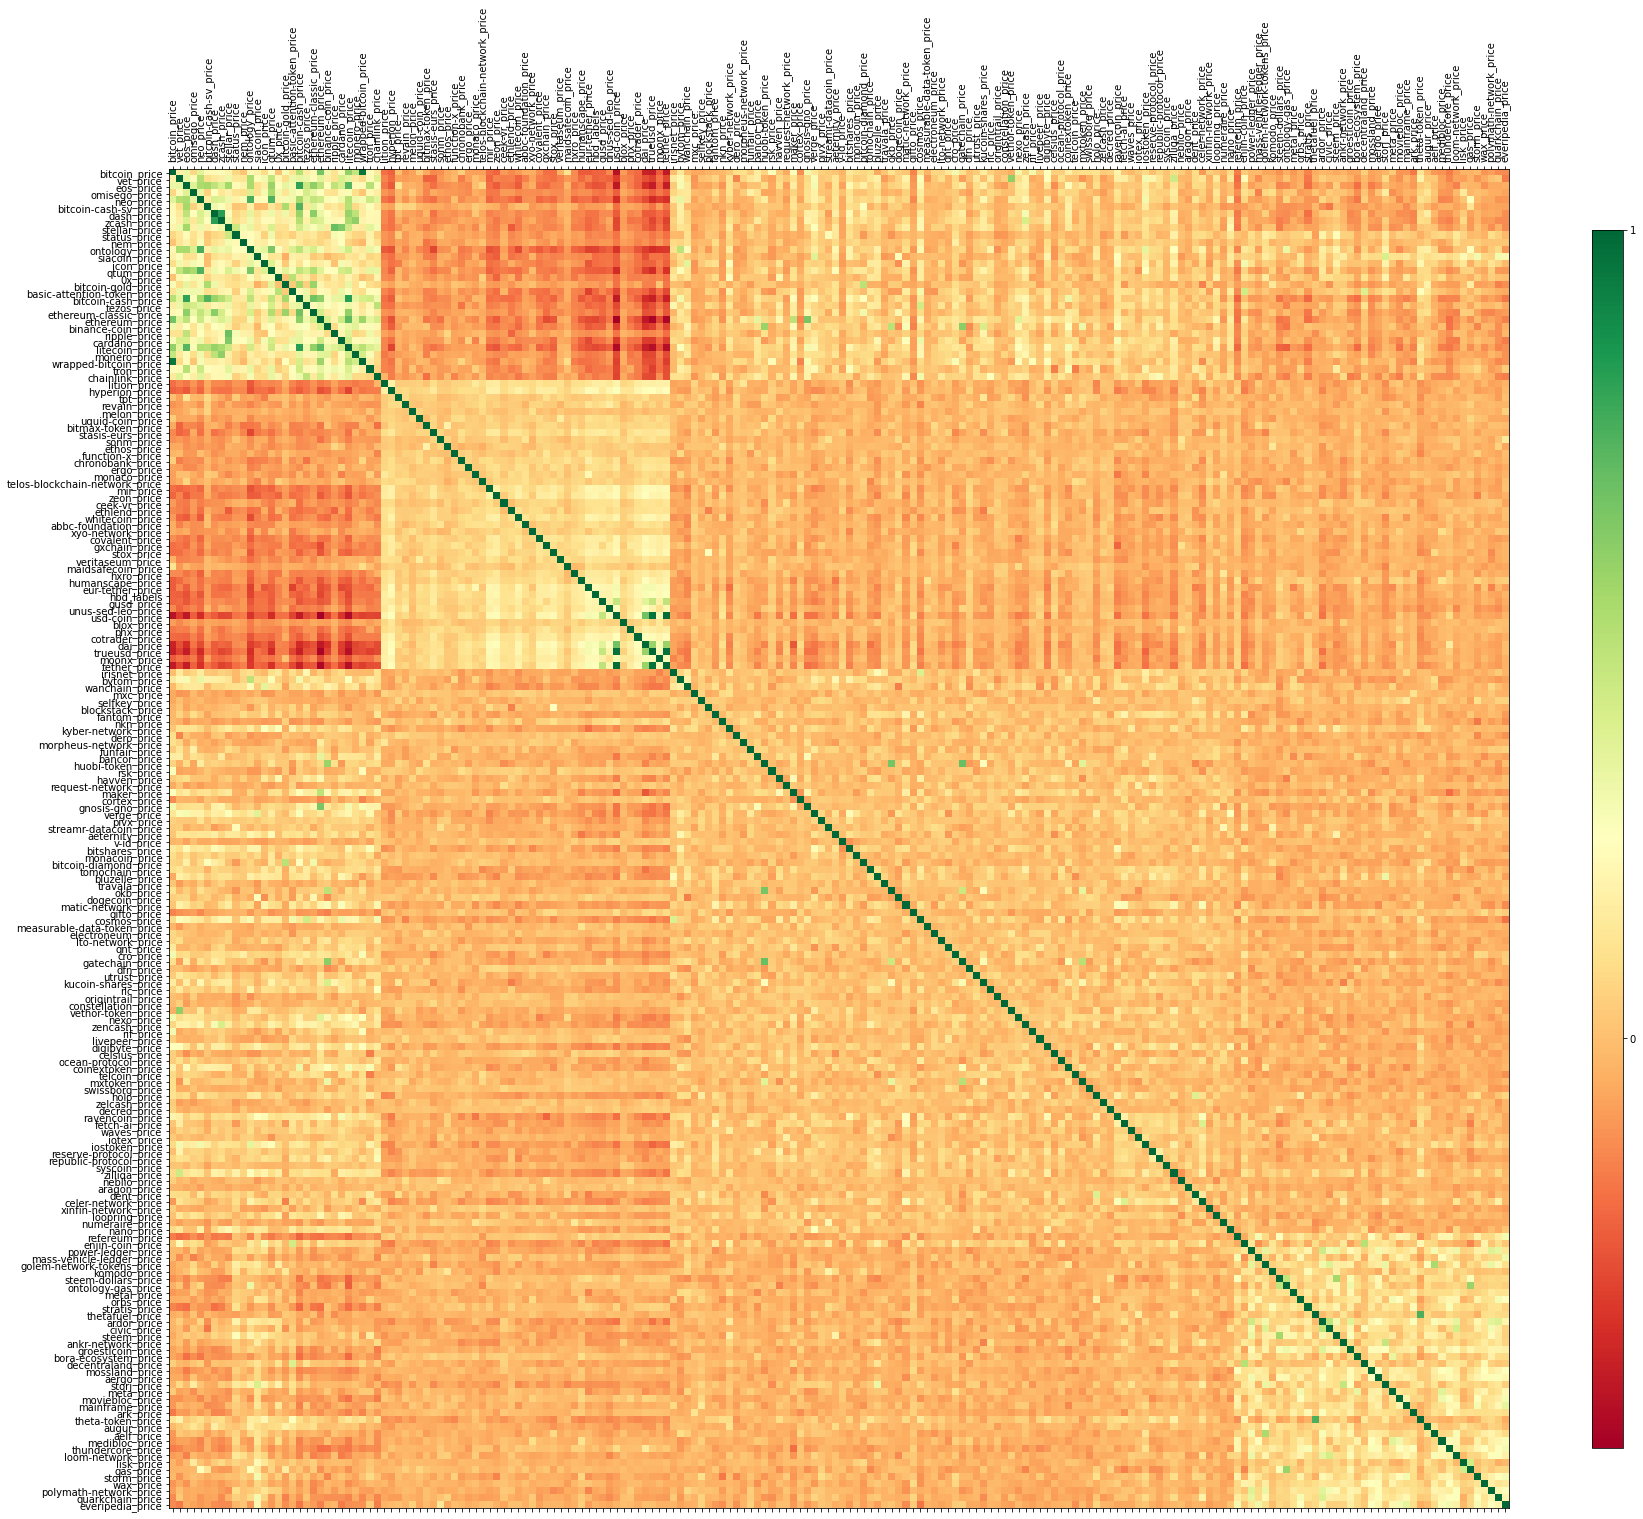

In [15]:
import scipy.cluster.hierarchy as spc
import matplotlib.pyplot as plt

df4 = df_reduced_T.T
X = df4.corr().values

d = spc.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = spc.linkage(d, method='complete')
ind = spc.fcluster(L, 0.5*d.max(), 'distance')
columns = [df4.columns.tolist()[i] for i in list((np.argsort(ind)))]
df_blocked = df4.reindex(columns, axis=1)

corr = df_blocked.corr()
    
fig, ax = plt.subplots(figsize=(30, 28))
cax = ax.matshow(corr, cmap='RdYlGn')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
plt.yticks(range(len(corr.columns)), corr.columns);

cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)


### 

        